In [1]:
import numpy as np
from scipy.stats import norm
import mne
import scipy.io
import scipy.signal as ss
from scipy import stats
from scipy.signal import hilbert,butter, lfilter,welch
from scipy.integrate import simps
from mne.time_frequency import psd_array_multitaper
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
import pandas as pd

### deviding the main EEG signal to 14 different frequency band

In [2]:
channel_num=21
pearson_acceptance_threshold=0.3
frequency_bands=[[1, 4],[4, 8],[8, 12],[12, 25], [25, 30],[30, 40],[40, 49],[8, 10],[10, 12],[12, 15],
                 [15, 18], [18, 25], [30, 35], [35, 40]]
###########to_do
delta_limit=[1, 4]
 #delta,  theta, alpha,  beta,    h_beta,  gamma,   h_gamma, alpha_1,alpha_2, beta_1,  beta_2, beta_3,  gama_1,  gama_2
    #[1, 4],[4, 8],[8, 12],[12, 25],[25, 30],[30, 40],[40, 49],[8, 10],[10, 12],[12, 15],[15, 18],[18, 25],[30, 35],[35, 40]

num_subject=np.array([1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,28,29,30,31,
                      32,35,36,37,38,39,40,41,42,43])

In [3]:
def bandPower(data, sampling_rate, frequency_bands,method='welch', window_sec=None):
    bp_absolute_list=[]
    bp_relative_list=[]
    for fb in frequency_bands:
        fb_array=np.asarray(fb)
        low_limitation, high_limitation = fb_array
        # Compute the modified periodogram (Welch)
        if method == 'welch':
            if window_sec is not None:
                num_of_sample_per_segment = window_sec * sampling_rate
            #TODO: change window_sec to list to solve low_limitation
            else:
                num_of_sample_per_segment = (2 / low_limitation) * sampling_rate
            #TODO: describe 
            freqs, psd = welch(data, sampling_rate, nperseg=num_of_sample_per_segment)
        elif method == 'multitaper':
             psd, freqs = psd_array_multitaper(data, sampling_rate, adaptive=True,
                                          normalization='full', verbose=0)
        # Frequency resolution
        freq_res = freqs[1] - freqs[0]
        
        # Find index of band in frequency vector
        idx_band = np.logical_and(freqs >= low_limitation, freqs <= high_limitation)
        # Integral approximation of the spectrum using parabola (Simpson's rule)
        bp = simps(psd[idx_band], dx=freq_res)
        bp_general=simps(psd, dx=freq_res)
        bp_relative=bp/bp_general
        bp_absolute_list.append(bp)
        bp_relative_list.append(bp_relative) 
        
    return(bp_absolute_list + bp_relative_list)  

In [3]:
###power_calculation###
band_power_all_band=np.zeros((channel_num,28))
for i in range(len(num_subject)):
    data= np.load('subject'+str(num_subject[i])+'_clean.npy')
    band_power_all_band_local=band_power_all_band
    for ii in range (channel_num):
        band_power_all_band_local[ii] = bandPower(data[ii,:], 250 , frequency_bands,'multitaper')
        
    np.save('eeg_data_'+str(num_subject[i])+'_band_power_all_band', band_power_all_band_local)

<ipython-input-2-61457e090168>:57: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(data, sampling_rate, adaptive=True,
<ipython-input-2-61457e090168>:57: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(data, sampling_rate, adaptive=True,
<ipython-input-2-61457e090168>:57: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(data, sampling_rate, adaptive=True,
<ipython-input-2-61457e090168>:57: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(data, sampling_rate, adaptive=True,
<ipython-input-2-61457e090168>:57: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(data, sampling_rate, adaptive=True,
<ipython-input-2-61457e090168>:57: RuntimeWarning: Iterative multi-taper PSD computation did not converge

In [71]:
###phase_lag_calculation###

def butterBandpass(data, lower_limit_filter, upper_limit_filter, sampling_rate, order=4):
    """
    This func is for filtering signal between lower and upper bounds
    the methods are used from scipy.signal lib
    """
    nyquist_coeff = 0.5 * sampling_rate
    low_frequences_filter = lower_limit_filter / nyquist_coeff
    high_frequences_filter = upper_limit_filter / nyquist_coeff
    numerator_filter, denominator_filter = butter(order, 
                                                  [low_frequences_filter, high_frequences_filter],
                                                  btype='band')

    # based on numinator and denominator the filter signal ...                                            
    filtered_signal = lfilter(numerator_filter, denominator_filter, data)
    return filtered_signal

In [45]:
###phase_lag_calculation###

for i in range(len(num_subject)):
    data= np.load('subject'+str(num_subject[i])+'_clean.npy')       

    
    phase_diff_delta=np.zeros((channel_num,channel_num))
    phase_diff_theta=np.zeros((channel_num,channel_num))
    phase_diff_alpha=np.zeros((channel_num,channel_num))
    phase_diff_beta=np.zeros((channel_num,channel_num))
    phase_diff_h_beta=np.zeros((channel_num,channel_num))
    phase_diff_beta1=np.zeros((channel_num,channel_num))
    phase_diff_beta2=np.zeros((channel_num,channel_num))
    phase_diff_beta3=np.zeros((channel_num,channel_num))
    phase_diff_gamma1=np.zeros((channel_num,channel_num))
    phase_diff_gamma2=np.zeros((channel_num,channel_num))
    
    for jj in range (channel_num):
        for j in range (channel_num):
            ch1_delta=filter_signal_delta[jj,:]
            ch2_delta=filter_signal_delta[j,:] 
            x1_delta= hilbert(ch1_delta)
            x2_delta = hilbert(ch2_delta)
            c_delta = np.inner( x1_delta, np.conj(x2_delta) )/np.sqrt( np.inner(x1_delta,np.conj(x1_delta)) * np.inner(x2_delta,np.conj(x2_delta)))
            phase_diff_delta[jj,j]= np.angle(c_delta)
       
            ch1_theta=filter_signal_theta[jj,:]
            ch2_theta=filter_signal_theta[j,:] 
            x1_theta= hilbert(ch1_theta)
            x2_theta = hilbert(ch2_theta)
            c_theta = np.inner( x1_theta, np.conj(x2_theta) )/np.sqrt( np.inner(x1_theta,np.conj(x1_theta)) * np.inner(x2_theta,np.conj(x2_theta)))
            phase_diff_theta[jj,j]= np.angle(c_theta)
       
            ch1_alpha=filter_signal_alpha[jj,:]
            ch2_alpha=filter_signal_alpha[j,:] 
            x1_alpha= hilbert(ch1_alpha)
            x2_alpha = hilbert(ch2_alpha)
            c_alpha = np.inner( x1_alpha, np.conj(x2_alpha) )/np.sqrt( np.inner(x1_alpha,np.conj(x1_alpha)) * np.inner(x2_alpha,np.conj(x2_alpha)))
            phase_diff_alpha[jj,j]= np.angle(c_alpha)
        
            ch1_beta=filter_signal_beta[jj,:]
            ch2_beta=filter_signal_beta[j,:] 
            x1_beta= hilbert(ch1_beta)
            x2_beta = hilbert(ch2_beta)
            c_beta= np.inner( x1_beta, np.conj(x2_beta) )/np.sqrt( np.inner(x1_beta,np.conj(x1_beta)) * np.inner(x2_beta,np.conj(x2_beta)))
            phase_diff_beta[jj,j]= np.angle(c_beta)
       
       
            ch1_h_beta=filter_signal_h_beta[jj,:]
            ch2_h_beta=filter_signal_h_beta[j,:] 
            x1_h_beta= hilbert(ch1_h_beta)
            x2_h_beta = hilbert(ch2_h_beta)
            c_h_beta = np.inner( x1_h_beta, np.conj(x2_h_beta) )/np.sqrt( np.inner(x1_h_beta,np.conj(x1_h_beta)) * np.inner(x2_h_beta,np.conj(x2_h_beta)))
            phase_diff_h_beta[jj,j]= np.angle(c_h_beta)
        
            ch1_beta1=filter_signal_beta1[jj,:]
            ch2_beta1=filter_signal_beta1[j,:] 
            x1_beta1= hilbert(ch1_beta1)
            x2_beta1 = hilbert(ch2_beta1)
            c_beta1= np.inner( x1_beta1, np.conj(x2_beta1) )/np.sqrt( np.inner(x1_beta1,np.conj(x1_beta1)) * np.inner(x2_beta1,np.conj(x2_beta1)))
            phase_diff_beta1[jj,j]= np.angle(c_beta1)
        
            ch1_beta2=filter_signal_beta2[jj,:]
            ch2_beta2=filter_signal_beta2[j,:] 
            x1_beta2= hilbert(ch1_beta2)
            x2_beta2 = hilbert(ch2_beta2)
            c_beta2 = np.inner( x1_beta2, np.conj(x2_beta2) )/np.sqrt( np.inner(x1_beta2,np.conj(x1_beta2)) * np.inner(x2_beta2,np.conj(x2_beta2)))
            phase_diff_beta2[jj,j]= np.angle(c_beta2)
       
            ch1_beta3=filter_signal_beta3[jj,:]
            ch2_beta3=filter_signal_beta3[j,:] 
            x1_beta3= hilbert(ch1_beta3)
            x2_beta3 = hilbert(ch2_beta3)
            c_beta3 = np.inner( x1_beta3, np.conj(x2_beta3) )/np.sqrt( np.inner(x1_beta3,np.conj(x1_beta3)) * np.inner(x2_beta3,np.conj(x2_beta3)))
            phase_diff_beta3[jj,j]= np.angle(c_beta3)
       
            ch1_gamma1=filter_signal_gamma_1[jj,:]
            ch2_gamma1=filter_signal_gamma_1[j,:] 
            x1_gamma1= hilbert(ch1_gamma1)
            x2_gamma1 = hilbert(ch2_gamma1)
            c_gamma1 = np.inner( x1_gamma1,np.conj(x2_gamma1) )/np.sqrt( np.inner(x1_gamma1,np.conj(x1_gamma1)) * np.inner(x2_gamma1,np.conj(x2_gamma1)))
            phase_diff_gamma1[jj,j]= np.angle(c_gamma1)
       
            ch1_gamma2=filter_signal_gamma_2[jj,:]
            ch2_gamma2=filter_signal_gamma_2[j,:] 
            x1_gamma2= hilbert(ch1_gamma2)
            x2_gamma2 = hilbert(ch2_gamma2)
            c_gamma2 = np.inner( x1_gamma2, np.conj(x2_gamma2) )/np.sqrt( np.inner(x1_gamma2,np.conj(x1_gamma2)) * np.inner(x2_gamma2,np.conj(x2_gamma2)))
            phase_diff_gamma2[jj,j]= np.angle(c_gamma2)
       
    phase_diff_all_band=[phase_diff_delta,phase_diff_theta,phase_diff_alpha,phase_diff_beta,phase_diff_h_beta,
                             phase_diff_beta1,phase_diff_beta2,phase_diff_beta3,phase_diff_gamma1,phase_diff_gamma2]                                                         
    np.save('eeg_data_'+str(num_subject[i])+'_phase_diff_all_band', phase_diff_all_band) 

KeyboardInterrupt: 

In [37]:
#coherence_calculation
for i in range(len(num_subother_ch_idxect)):
    data= np.load('subother_ch_idxect'+str(num_subother_ch_idxect[i])+'_clean.npy')
    coherence=np.empty((10,channel_num,channel_num))
    for ch_idx in range(channel_num):
        for other_ch_idx in range(channel_num):
            selected_channel=data[ch_idx,:]
            other_selected_channel=data[other_ch_idx,:]
#             power_selected_channel=np.log(np.mean(np.abs(selected_channel**2)))
#             power_other_selected_channel=np.log(np.mean(np.abs(other_selected_channel**2)))
            frequnsies,spectral_density=ss.coherence(selected_channel, other_selected_channel,250, window='hann', 
                                                     nperseg=250, noverlap=None, nfft=None, detrend='constant', axis=-1)
            coherence_delta = np.mean(spectral_density[1:4])
            coherence_theta =np.mean(spectral_density[ 4:8])
            coherence_alpha = np.mean(spectral_density[8:12])
            coherence_beta =np.mean(spectral_density[12:25])
            coherence_h_beta =np.mean(spectral_density[25:30])
            coherence_beta1 = np.mean(spectral_density[12:15])
            coherence_beta2 = np.mean(spectral_density[15:18])
            coherence_beta3 = np.mean(spectral_density[18:25])
            coherence_gamma_1 = np.mean(spectral_density[30:40])
            coherence_gamma_2 = np.mean(spectral_density[40:49])
            coherence[:,ch_idx,other_ch_idx]=(coherence_delta,coherence_theta,coherence_alpha,coherence_beta,
                                              coherence_h_beta,coherence_beta1,coherence_beta2,coherence_beta3,
                                              coherence_gamma_1,coherence_gamma_2)
    np.save('eeg_data'+str(num_subother_ch_idxect[i])+'_coherence_ten_band', coherence) 
    

[[[1.         0.99334772 0.95888977 ... 0.00602408 0.02109145 0.04830207]
  [0.99334772 1.         0.98358213 ... 0.00834449 0.01914267 0.04759259]
  [0.95888977 0.98358213 1.         ... 0.01246902 0.01744716 0.0480499 ]
  ...
  [0.00602408 0.00834449 0.01246902 ... 1.         0.51018991 0.00438879]
  [0.02109145 0.01914267 0.01744716 ... 0.51018991 1.         0.410747  ]
  [0.04830207 0.04759259 0.0480499  ... 0.00438879 0.410747   1.        ]]

 [[1.         0.99204482 0.956319   ... 0.03364301 0.00423149 0.00244397]
  [0.99204482 1.         0.98429477 ... 0.04894103 0.00770838 0.00229753]
  [0.956319   0.98429477 1.         ... 0.07337598 0.01434877 0.00299354]
  ...
  [0.03364301 0.04894103 0.07337598 ... 1.         0.61869643 0.1399109 ]
  [0.00423149 0.00770838 0.01434877 ... 0.61869643 1.         0.65646759]
  [0.00244397 0.00229753 0.00299354 ... 0.1399109  0.65646759 1.        ]]

 [[1.         0.99318885 0.96618687 ... 0.17057122 0.10213086 0.06987725]
  [0.99318885 1.      

[[[1.         0.98645543 0.9375297  ... 0.03184458 0.01595222 0.02324136]
  [0.98645543 1.         0.98094045 ... 0.04054257 0.01479491 0.02655945]
  [0.9375297  0.98094045 1.         ... 0.04850175 0.01552506 0.03199194]
  ...
  [0.03184458 0.04054257 0.04850175 ... 1.         0.43877992 0.09177849]
  [0.01595222 0.01479491 0.01552506 ... 0.43877992 1.         0.75004645]
  [0.02324136 0.02655945 0.03199194 ... 0.09177849 0.75004645 1.        ]]

 [[1.         0.98843913 0.95128907 ... 0.11424208 0.02115896 0.07125867]
  [0.98843913 1.         0.98604839 ... 0.11852849 0.0216235  0.07434297]
  [0.95128907 0.98604839 1.         ... 0.11825633 0.0221836  0.0776981 ]
  ...
  [0.11424208 0.11852849 0.11825633 ... 1.         0.50003682 0.1179204 ]
  [0.02115896 0.0216235  0.0221836  ... 0.50003682 1.         0.77171206]
  [0.07125867 0.07434297 0.0776981  ... 0.1179204  0.77171206 1.        ]]

 [[1.         0.98918385 0.95514976 ... 0.10677816 0.01492368 0.06374401]
  [0.98918385 1.      

[[[1.         0.98902352 0.94688082 ... 0.06995885 0.00858446 0.00256282]
  [0.98902352 1.         0.98346121 ... 0.0778926  0.00820364 0.00266986]
  [0.94688082 0.98346121 1.         ... 0.08622951 0.00731515 0.00349912]
  ...
  [0.06995885 0.0778926  0.08622951 ... 1.         0.57492188 0.15486309]
  [0.00858446 0.00820364 0.00731515 ... 0.57492188 1.         0.74700432]
  [0.00256282 0.00266986 0.00349912 ... 0.15486309 0.74700432 1.        ]]

 [[1.         0.99059712 0.95798848 ... 0.12680294 0.00665806 0.01447434]
  [0.99059712 1.         0.98772756 ... 0.1353917  0.00672253 0.01676382]
  [0.95798848 0.98772756 1.         ... 0.14051785 0.00660713 0.02061422]
  ...
  [0.12680294 0.1353917  0.14051785 ... 1.         0.62233344 0.26099046]
  [0.00665806 0.00672253 0.00660713 ... 0.62233344 1.         0.82983637]
  [0.01447434 0.01676382 0.02061422 ... 0.26099046 0.82983637 1.        ]]

 [[1.         0.99238402 0.96786506 ... 0.25016045 0.03752538 0.01447244]
  [0.99238402 1.      

[[[1.         0.98477217 0.93553471 ... 0.09542192 0.03835741 0.06204854]
  [0.98477217 1.         0.98196347 ... 0.10207999 0.04150705 0.0658838 ]
  [0.93553471 0.98196347 1.         ... 0.10731935 0.04345956 0.06866987]
  ...
  [0.09542192 0.10207999 0.10731935 ... 1.         0.40047128 0.06665319]
  [0.03835741 0.04150705 0.04345956 ... 0.40047128 1.         0.77894216]
  [0.06204854 0.0658838  0.06866987 ... 0.06665319 0.77894216 1.        ]]

 [[1.         0.9890854  0.95478782 ... 0.06443349 0.05430601 0.09407259]
  [0.9890854  1.         0.98777631 ... 0.06879747 0.0564419  0.09957091]
  [0.95478782 0.98777631 1.         ... 0.07486733 0.05677286 0.102805  ]
  ...
  [0.06443349 0.06879747 0.07486733 ... 1.         0.38263296 0.07355059]
  [0.05430601 0.0564419  0.05677286 ... 0.38263296 1.         0.81926361]
  [0.09407259 0.09957091 0.102805   ... 0.07355059 0.81926361 1.        ]]

 [[1.         0.99061934 0.95991763 ... 0.18365138 0.00904325 0.00730014]
  [0.99061934 1.      

[[[1.         0.97019516 0.85903521 ... 0.00657945 0.0204019  0.02906177]
  [0.97019516 1.         0.95562691 ... 0.0049516  0.02319979 0.03664488]
  [0.85903521 0.95562691 1.         ... 0.00380127 0.02534151 0.04391784]
  ...
  [0.00657945 0.0049516  0.00380127 ... 1.         0.58515788 0.18463642]
  [0.0204019  0.02319979 0.02534151 ... 0.58515788 1.         0.77243981]
  [0.02906177 0.03664488 0.04391784 ... 0.18463642 0.77243981 1.        ]]

 [[1.         0.97324788 0.87971091 ... 0.15477722 0.05025818 0.02470842]
  [0.97324788 1.         0.96402939 ... 0.15828105 0.04592132 0.02090666]
  [0.87971091 0.96402939 1.         ... 0.15575546 0.03845816 0.01578547]
  ...
  [0.15477722 0.15828105 0.15575546 ... 1.         0.64239245 0.33495704]
  [0.05025818 0.04592132 0.03845816 ... 0.64239245 1.         0.86455707]
  [0.02470842 0.02090666 0.01578547 ... 0.33495704 0.86455707 1.        ]]

 [[1.         0.9802785  0.91629693 ... 0.17102703 0.01868042 0.00541567]
  [0.9802785  1.      

[[[1.         0.98553245 0.94130717 ... 0.01376103 0.06437203 0.09029684]
  [0.98553245 1.         0.98440545 ... 0.01313211 0.06803419 0.10237815]
  [0.94130717 0.98440545 1.         ... 0.01259644 0.06849959 0.11024152]
  ...
  [0.01376103 0.01313211 0.01259644 ... 1.         0.63162973 0.1491729 ]
  [0.06437203 0.06803419 0.06849959 ... 0.63162973 1.         0.67308027]
  [0.09029684 0.10237815 0.11024152 ... 0.1491729  0.67308027 1.        ]]

 [[1.         0.98443618 0.93757368 ... 0.08024097 0.00970591 0.01760478]
  [0.98443618 1.         0.98351338 ... 0.08300703 0.01014869 0.02188921]
  [0.93757368 0.98351338 1.         ... 0.0847049  0.01025529 0.02594755]
  ...
  [0.08024097 0.08300703 0.0847049  ... 1.         0.59920883 0.15748673]
  [0.00970591 0.01014869 0.01025529 ... 0.59920883 1.         0.73187517]
  [0.01760478 0.02188921 0.02594755 ... 0.15748673 0.73187517 1.        ]]

 [[1.         0.9883644  0.95299264 ... 0.16838932 0.01432687 0.00955114]
  [0.9883644  1.      

[[[1.         0.98872162 0.94494996 ... 0.01848971 0.00942273 0.02121378]
  [0.98872162 1.         0.9824543  ... 0.02567926 0.00799636 0.02332435]
  [0.94494996 0.9824543  1.         ... 0.03557268 0.00692961 0.02682193]
  ...
  [0.01848971 0.02567926 0.03557268 ... 1.         0.60265458 0.08801467]
  [0.00942273 0.00799636 0.00692961 ... 0.60265458 1.         0.61309823]
  [0.02121378 0.02332435 0.02682193 ... 0.08801467 0.61309823 1.        ]]

 [[1.         0.98870323 0.94936132 ... 0.07291262 0.01006365 0.02145734]
  [0.98870323 1.         0.9849605  ... 0.08721567 0.00950155 0.02223202]
  [0.94936132 0.9849605  1.         ... 0.10069124 0.00920781 0.02541358]
  ...
  [0.07291262 0.08721567 0.10069124 ... 1.         0.57983904 0.17879673]
  [0.01006365 0.00950155 0.00920781 ... 0.57983904 1.         0.77641153]
  [0.02145734 0.02223202 0.02541358 ... 0.17879673 0.77641153 1.        ]]

 [[1.         0.99152402 0.96346173 ... 0.15160897 0.02036869 0.0165198 ]
  [0.99152402 1.      

[[[1.         0.98701022 0.95098948 ... 0.01958155 0.28189566 0.33133869]
  [0.98701022 1.         0.98811163 ... 0.02180162 0.31011469 0.36393414]
  [0.95098948 0.98811163 1.         ... 0.02330058 0.32999794 0.38670745]
  ...
  [0.01958155 0.02180162 0.02330058 ... 1.         0.34541092 0.04350676]
  [0.28189566 0.31011469 0.32999794 ... 0.34541092 1.         0.78844944]
  [0.33133869 0.36393414 0.38670745 ... 0.04350676 0.78844944 1.        ]]

 [[1.         0.98829085 0.95102843 ... 0.04115915 0.05401055 0.10371658]
  [0.98829085 1.         0.98675328 ... 0.04658067 0.05662845 0.11292779]
  [0.95102843 0.98675328 1.         ... 0.05243841 0.0585221  0.12111751]
  ...
  [0.04115915 0.04658067 0.05243841 ... 1.         0.45641287 0.05724019]
  [0.05401055 0.05662845 0.0585221  ... 0.45641287 1.         0.72231983]
  [0.10371658 0.11292779 0.12111751 ... 0.05724019 0.72231983 1.        ]]

 [[1.         0.9903892  0.95885538 ... 0.23802211 0.07353754 0.02015338]
  [0.9903892  1.      

[[[1.         0.98627027 0.94911968 ... 0.03320834 0.01264026 0.02248671]
  [0.98627027 1.         0.98775203 ... 0.03583307 0.01319266 0.02611803]
  [0.94911968 0.98775203 1.         ... 0.03829542 0.01358685 0.0298329 ]
  ...
  [0.03320834 0.03583307 0.03829542 ... 1.         0.6819646  0.17410309]
  [0.01264026 0.01319266 0.01358685 ... 0.6819646  1.         0.61947624]
  [0.02248671 0.02611803 0.0298329  ... 0.17410309 0.61947624 1.        ]]

 [[1.         0.9911932  0.96731206 ... 0.1401971  0.06816395 0.04371956]
  [0.9911932  1.         0.99212284 ... 0.15153549 0.07314548 0.04473136]
  [0.96731206 0.99212284 1.         ... 0.16070252 0.07516154 0.04340093]
  ...
  [0.1401971  0.15153549 0.16070252 ... 1.         0.62725064 0.22833948]
  [0.06816395 0.07314548 0.07516154 ... 0.62725064 1.         0.79653165]
  [0.04371956 0.04473136 0.04340093 ... 0.22833948 0.79653165 1.        ]]

 [[1.         0.99099044 0.96567317 ... 0.17532495 0.07031195 0.04414732]
  [0.99099044 1.      

[[[1.         0.99494741 0.97788113 ... 0.09482769 0.2269585  0.2470338 ]
  [0.99494741 1.         0.99379269 ... 0.09780611 0.22888748 0.25290576]
  [0.97788113 0.99379269 1.         ... 0.10235635 0.22884316 0.25804766]
  ...
  [0.09482769 0.09780611 0.10235635 ... 1.         0.21660129 0.0311611 ]
  [0.2269585  0.22888748 0.22884316 ... 0.21660129 1.         0.80236445]
  [0.2470338  0.25290576 0.25804766 ... 0.0311611  0.80236445 1.        ]]

 [[1.         0.98821219 0.95017301 ... 0.03310409 0.06183307 0.07620925]
  [0.98821219 1.         0.98630526 ... 0.04097869 0.06562732 0.08138323]
  [0.95017301 0.98630526 1.         ... 0.05056367 0.06947712 0.08702006]
  ...
  [0.03310409 0.04097869 0.05056367 ... 1.         0.29815376 0.05401668]
  [0.06183307 0.06562732 0.06947712 ... 0.29815376 1.         0.84028822]
  [0.07620925 0.08138323 0.08702006 ... 0.05401668 0.84028822 1.        ]]

 [[1.         0.98848937 0.95351969 ... 0.05396039 0.00798003 0.0085026 ]
  [0.98848937 1.      

In [3]:
# data= np.load('subject33_clean.npy')
# coherence=np.empty((10,21,21))
# for jj in range(21):
#     for j in range(21):
#         ch_m=data[jj,:]
#         ch_n=data[j,:]
#         power_f=np.log(np.mean(np.abs(ch_m**2)))
#         power_ff=np.log(np.mean(np.abs(ch_n**2)))
#         fxx,cxx=ss.coherence(ch_m, ch_n,250, window='hann', nperseg=250, noverlap=None, nfft=None, detrend='constant', axis=-1)
#         c_delta = np.mean(cxx[1:4])
#         c_theta =np.mean(cxx[ 4:8])
#         c_alpha = np.mean(cxx[8:12])
#         c_beta =np.mean(cxx[12:25])
#         c_h_beta =np.mean(cxx[25:30])
#         c_beta1 = np.mean(cxx[12:15])
#         c_beta2 = np.mean(cxx[15:18])
#         c_beta3 = np.mean(cxx[18:25])
#         c_gamma_1 = np.mean(cxx[30:40])
#         c_gamma_2 = np.mean(cxx[40:49])
#         coherence[:,jj,j]=(c_delta,c_theta,c_alpha,c_beta,c_h_beta,c_beta1,c_beta2,c_beta3,c_gamma_1,c_gamma_2)
        

In [10]:
# (c_delta,c_theta,c_alpha,c_beta,c_h_beta,c_beta1,c_beta2,c_beta3,c_gamma_1,c_gamma_2)
# #delta = 1, 4, 
# #theta = 4, 8,
# #alpha =  8, 12, 
# #beta = 12, 25,
# #h_beta = 25, 30, 
# #beta1 = 12, 15,
# #beta2 = 15, 18,
# #beta3 = 18, 25, 
# #gamma_1 = 30, 40, 
# #gamma_2 = 40, 49, 

In [72]:
###Amplitude_asymmetry###
for i in range(len(num_subject)):
    data= np.load('subject'+str(num_subject[i])+'_clean.npy') 
    #########to do sampling rate
    filter_signal_delta = butterBandpass(data, 1, 4, 250)
    filter_signal_theta = butterBandpass(data, 4, 8, 250)
    filter_signal_alpha = butterBandpass(data, 8, 12, 250)
    filter_signal_beta = butterBandpass(data, 12, 25, 250)
    filter_signal_h_beta = butterBandpass(data, 25, 30, 250)
    filter_signal_beta1 = butterBandpass(data, 12, 15, 250)
    filter_signal_beta2 = butterBandpass(data, 15, 18, 250)
    filter_signal_beta3 = butterBandpass(data, 18, 25, 250)
    filter_signal_gamma_1 = butterBandpass(data, 30, 40, 250)
    filter_signal_gamma_2 = butterBandpass(data, 40, 49, 250)

    Amp_assym_delta=np.zeros((channel_num,channel_num))
    Amp_assym_theta=np.zeros((channel_num,channel_num))
    Amp_assym_alpha=np.zeros((channel_num,channel_num))
    Amp_assym_beta=np.zeros((channel_num,channel_num))
    Amp_assym_h_beta=np.zeros((channel_num,channel_num))
    Amp_assym_beta1=np.zeros((channel_num,channel_num))
    Amp_assym_beta2=np.zeros((channel_num,channel_num))
    Amp_assym_beta3=np.zeros((channel_num,channel_num))
    Amp_assym_gamma_1=np.zeros((channel_num,channel_num))
    Amp_assym_gamma_2=np.zeros((channel_num,channel_num))

    for jj in range (channel_num):
        for j in range (channel_num):
            selected_channel_delta=filter_signal_delta[jj,:]
            ch2_delta=filter_signal_delta[j,:] 
            p_delta_1=np.log(np.mean(np.abs(selected_channel_delta**2)))
            p_delta_2=np.log(np.mean(np.abs(ch2_delta**2)))
            Amp_assym_delta[jj,j]=p_delta_1-p_delta_2
        
            selected_channel_theta=filter_signal_theta[jj,:]
            ch2_theta=filter_signal_theta[j,:] 
            p_theta_1=np.log(np.mean(np.abs(selected_channel_theta**2)))
            p_theta_2=np.log(np.mean(np.abs(ch2_theta**2)))
            Amp_assym_theta[jj,j]=p_theta_1-p_theta_2
        
            selected_channel_alpha=filter_signal_alpha[jj,:]
            ch2_alpha=filter_signal_alpha[j,:] 
            p_alpha_1=np.log(np.mean(np.abs(ch1_alpha**2)))
            p_alpha_2=np.log(np.mean(np.abs(ch2_alpha**2)))
            Amp_assym_alpha[jj,j]=p_alpha_1-p_alpha_2
        
            selected_channel_beta=filter_signal_beta[jj,:]
            ch2_beta=filter_signal_beta[j,:] 
            p_beta_1=np.log(np.mean(np.abs(ch1_beta**2)))
            p_beta_2=np.log(np.mean(np.abs(ch2_beta**2)))
            Amp_assym_beta[jj,j]=p_beta_1-p_beta_2
        
            selected_channel_h_beta=filter_signal_h_beta[jj,:]
            ch2_h_beta=filter_signal_h_beta[j,:] 
            p_h_beta_1=np.log(np.mean(np.abs(ch1_h_beta**2)))
            p_h_beta_2=np.log(np.mean(np.abs(ch2_h_beta**2)))
            Amp_assym_h_beta[jj,j]=p_h_beta_1-p_h_beta_2
        
            selected_channel_beta_1=filter_signal_beta1[jj,:]
            ch2_beta_1=filter_signal_beta1[j,:] 
            p_beta_1_1=np.log(np.mean(np.abs(ch1_beta_1**2)))
            p_beta_1_2=np.log(np.mean(np.abs(ch2_beta_1**2)))
            Amp_assym_beta1[jj,j]=p_beta_1_1-p_beta_1_2
        
            selected_channel_beta_2=filter_signal_beta2[jj,:]
            ch2_beta_2=filter_signal_beta2[j,:] 
            p_beta_2_1=np.log(np.mean(np.abs(selected_channel_beta_2**2)))
            p_beta_2_2=np.log(np.mean(np.abs(ch2_beta_2**2)))
            Amp_assym_beta2[jj,j]=p_beta_2_1-p_beta_2_2
        
            selected_channel_beta_3=filter_signal_beta3[jj,:]
            ch2_beta_3=filter_signal_beta3[j,:] 
            p_beta_3_1=np.log(np.mean(np.abs(selected_channel_beta_3**2)))
            p_beta_3_2=np.log(np.mean(np.abs(ch2_beta_3**2)))
            Amp_assym_beta3[jj,j]=p_beta_3_1-p_beta_3_2
        
            selected_channel_gamma_1=filter_signal_gamma_1[jj,:]
            ch2_gamma_1=filter_signal_gamma_1[j,:] 
            p_gamma_1_1=np.log(np.mean(np.abs(selected_channel_gamma_1**2)))
            p_gamma_1_2=np.log(np.mean(np.abs(ch2_gamma_1**2)))
            Amp_assym_gamma_1[jj,j]=p_gamma_1_1-p_gamma_1_2
        
            selected_channel_gamma_2=filter_signal_gamma_2[jj,:]
            ch2_gamma_2=filter_signal_gamma_2[j,:] 
            p_gamma_2_1=np.log(np.mean(np.abs(selected_channel_gamma_2**2)))
            p_gamma_2_2=np.log(np.mean(np.abs(ch2_gamma_2**2)))
            Amp_assym_gamma_2[jj,j]=p_gamma_2_1-p_gamma_2_2
    
    Amp_assym_all_band = [Amp_assym_delta,Amp_assym_theta,Amp_assym_alpha,Amp_assym_beta,
                 Amp_assym_h_beta,Amp_assym_beta1,Amp_assym_beta2,Amp_assym_beta3,
                 Amp_assym_gamma_1, Amp_assym_gamma_2]
    np.save('s'+str(num_subject[i])+'_Amp_assym_all_band', Amp_assym_all_band)    

In [53]:
###  DFA  ###

def dfa(x, scale_lim=[5,9], scale_dens=0.32, show=False):
    """
    Detrended Fluctuation Analysis - measures power law scaling coefficient
    of the given signal *x*.
    More details about the algorithm you can find e.g. here:
    Hardstone, R. et al. Detrended fluctuation analysis: A scale-free 
    view on neuronal oscillations, (2012).
    Args:
    -----
      *x* : numpy.array
        one dimensional data vector
      *scale_lim* = [5,9] : list of length 2 
        boundaries of the scale, where scale means windows among which RMS
        is calculated. Numbers from list are exponents of 2 to the power
        of X, eg. [5,9] is in fact [2**5, 2**9].
        You can think of it that if your signal is sampled with F_s = 128 Hz,
        then the lowest considered scale would be 2**5/128 = 32/128 = 0.25,
        so 250 ms.
        mine: fs=1000, 2**5/1000=32/1000=0.032
      *scale_dens* = 0.25 : float
        density of scale divisions, eg. for 0.25 we get 2**[5, 5.25, 5.5, ... ] 
      *show* = False
        if True it shows matplotlib log-log plot.
    Returns:
    --------
      *scales* : numpy.array
        vector of scales (x axis)
      *fluct* : numpy.array
        fluctuation function values (y axis)
      *alpha* : float
        estimation of DFA exponent
    """
    # cumulative sum of data with substracted offset
    y = np.cumsum(x - np.mean(x))
    scales = (2**np.arange(scale_lim[0], scale_lim[1], scale_dens)).astype(np.int)
    fluct = np.zeros(len(scales))
    # computing RMS for each window
    for e, sc in enumerate(scales):
        fluct[e] = np.sqrt(np.mean(calcRms(y, sc)**2))
    # fitting a line to rms data
    coeff = np.polyfit(np.log2(scales), np.log2(fluct), 1)
    if show:
        fluctfit = 2**np.polyval(coeff,np.log2(scales))
        plt.loglog(scales, fluct, 'bo')
        plt.loglog(scales, fluctfit, 'r', label=r'$\alpha$ = %0.2f'%coeff[0])
        plt.title('DFA')
        plt.xlabel(r'$\log_{10}$(time window)')
        plt.ylabel(r'$\log_{10}$<F(t)>')
        plt.legend()
        plt.show()
    return scales, fluct, coeff[0]

In [54]:
###  DFA  ###

def calcRms(x, scale):
    """
    windowed Root Mean Square (RMS) with linear detrending.
    
    Args:
    -----
      *x* : numpy.array
        one dimensional data vector
      *scale* : int
        length of the window in which RMS will be calculaed
    Returns:
    --------
      *rms* : numpy.array
        RMS data in each window with length len(x)//scale
    """
    # making an array with data divided in windows
    shape = (x.shape[0]//scale, scale)
    X = np.lib.stride_tricks.as_strided(x,shape=shape)
    # vector of x-axis points to regression
    scale_ax = np.arange(scale)
    rms = np.zeros(X.shape[0])
    for e, xcut in enumerate(X):
        coeff = np.polyfit(scale_ax, xcut, 1)
        xfit = np.polyval(coeff, scale_ax)
        # detrending and computing RMS of each window
        rms[e] = np.sqrt(np.mean((xcut-xfit)**2))
    return rms

In [56]:
###  DFA  ###


for ii in range(len(num_subject)):
    data= np.load('subject'+str(num_subject[ii])+'_clean.npy') 
    dfas_delta=np.empty(21)
    dfas_theta=np.empty(21)
    dfas_alpha=np.empty(21)
    dfas_beta=np.empty(21)
    dfas_h_beta=np.empty(21)
    dfas_beta1=np.empty(21)
    dfas_beta2=np.empty(21)
    dfas_beta3=np.empty(21)
    dfas_gamma1=np.empty(21)
    dfas_gamma2=np.empty(21)
    
    filter_signal_delta = butterBandpass(data, 1, 4, 250)
    filter_signal_theta = butterBandpass(data, 4, 8, 250)
    filter_signal_alpha = butterBandpass(data, 8, 12, 250)
    filter_signal_beta = butterBandpass(data, 12, 25, 250)
    filter_signal_h_beta = butterBandpass(data, 25, 30, 250)
    filter_signal_beta1 = butterBandpass(data, 12, 15, 250)
    filter_signal_beta2 = butterBandpass(data, 15, 18, 250)
    filter_signal_beta3 = butterBandpass(data, 18, 25, 250)
    filter_signal_gamma1 = butterBandpass(data, 30, 40, 250)
    filter_signal_gamma2 = butterBandpass(data, 40, 49, 250)
    
    for i in range (21):
            x_delta = np.abs(hilbert(filter_signal_delta[i]))
            scales, fluct, alpha_factor_delta = dfa(x_delta, show=0)
            dfas_delta[i]=alpha_factor_delta
        
            x_theta = np.abs(hilbert(filter_signal_theta[i]))
            scales, fluct, alpha_factor_theta= dfa(x_theta, show=0)
            dfas_theta[i]=alpha_factor_theta
        
            x_alpha= np.abs(hilbert(filter_signal_alpha[i]))
            scales, fluct, alpha_factor_alpha = dfa(x_alpha, show=0)
            dfas_alpha[i]=alpha_factor_alpha
        
            x_beta = np.abs(hilbert(filter_signal_beta[i]))
            scales, fluct, alpha_factor_beta = dfa(x_beta, show=0)
            dfas_beta[i]=alpha_factor_beta
        
            x_h_beta = np.abs(ss.hilbert(filter_signal_h_beta[i]))
            scales, fluct, alpha_factor_h_beta = dfa(x_h_beta, show=0)
            dfas_h_beta[i]=alpha_factor_h_beta
        
            x_beta1 = np.abs(hilbert(filter_signal_beta1[i]))
            scales, fluct, alpha_factor_beta1 = dfa(x_beta1, show=0)
            dfas_beta1[i]=alpha_factor_beta1
        
            x_beta2 = np.abs(hilbert(filter_signal_beta2[i]))
            scales, fluct, alpha_factor_beta2 = dfa(x_beta2, show=0)
            dfas_beta2[i]=alpha_factor_beta2
        
            x_beta3 = np.abs(hilbert(filter_signal_beta3[i]))
            scales, fluct, alpha_factor_beta3 = dfa(x_beta3, show=0)
            dfas_beta3[i]=alpha_factor_beta3
        
            x_gamma1 = np.abs(hilbert(filter_signal_gamma1[i]))
            scales, fluct, alpha_factor_gamma1 = dfa(x_gamma1, show=0)
            dfas_gamma1[i]=alpha_factor_gamma1
        
            x_gamma2 = np.abs(hilbert(filter_signal_gamma2[i]))
            scales, fluct, alpha_factor_gamma2 = dfa(x_gamma2, show=0)
            dfas_gamma2[i]=alpha_factor_gamma2
        
            dfa_all_band=[dfas_delta,dfas_theta,dfas_alpha,dfas_beta,dfas_h_beta,
                          dfas_beta1,dfas_beta2,dfas_beta3,dfas_gamma1,dfas_gamma2]                                                         
    np.save('s'+str(num_subject[ii])+'_DFA_all_band', dfa_all_band)

<ipython-input-53-9c4dda46f47a>:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scales = (2**np.arange(scale_lim[0], scale_lim[1], scale_dens)).astype(np.int)


# result analysis

In [54]:
###power_calculation###
power=np.empty((0,(channel_num*28)))
#28 meansthe number of frequency bands(14) by 2(which means relative and absolute power)
for i in range(len(num_subject)):
    subject_data=np.load('eeg_data_'+str(num_subject[i])+'_band_power_all_band.npy')
    subjet_data=subjet_data.reshape((1,(channel_num*28)))
    power=np.append(power,subjet_data,axis=0) 
    
zscore_power=np.empty(power.shape)
for ii in range(zscore_power.shape[1]):
    zscore_power[:,ii]=stats.zscore(power[:,ii])
    
for i in range(zscore_power.shape[1]):
    anomaly_index=[]
    for j in range(zscore_power.shape[0]):
        if zscore_power[j,i] >3.5 or zscore_power[j,i]<-3.5:
                anomaly_index=np.append(anomaly_index,i)
    if len(anomaly_index)>10:
        zscore_power=np.delete(zscore_power,i,1)      

In [ ]:
# ### Feature's Address###
# import numpy as np
# import pandas as pd
# ch=np.asarray(('Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','Cz','Fz','Pz','A2','A1'))
# ch_adress= np.vstack((ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch))
# ch_adress=ch_adress.reshape((1,588))

# rhytm=np.asarray(('Delta','Theta','Alpha','Beta','High_Beta','Gamma','High_Gamma','Alpha1','Alpha2','Beta1','Beta2',
#                'Beta3','Gamma1','Gamma2','r_delta','r_theta','r_alpha','r_beta','r_h_beta','r_gamma','r_h_gamma',
#                'r_alpha_1','r_alpha_2','r_beta_1','r_beta_2','r_beta_3','r_gamma_1','r_gamma_2',))
# rhytm_adress= np.vstack((rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,
#                          rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm))

# rhytm_adress=rhytm_adress.T
# rhytm_adress=rhytm_adress.reshape((1,588))
# power_address=np.vstack((rhytm_adress,ch_adress))

In [7]:
#### cognitive test scores###

Memory=np.array([2,1.7,2.8,4.5,3.8,1,1,3,3,1.5,3,3,1,2,1,3,1.8,1.2,3,1,1.3,1.8,3.5,1.5,1.7,2.2,3.2,1,
                 2.5,3,3,1.3,1.5,1.5,1.5,2.4,5,3])
Attention=np.array([3.2,1.8,3.6,1,0.5,2.5,1,1.8,2.9,2,3.3,3.2,1.5,1,1.75,2.5,3.4,3.1,2.8,1,3.8,4,3.1,3.3,
                   4.3,4,2.5,1,2.3,4,3,3.2,1.5,1.9,1,2,2.3,4])
Executive_Function=np.array([5,4,3.5,1.7,2,3.5,3.5,4.5,4.8,3.5,3.1,4,2.6,2.6,2.8,4.6,4.2,2.7,3.7,3.9,4.2,4,4,
                             4.7,3.8,3.6,5,2.4,3,4,2.8,2.1,3.5,4,4,4.9,1,1])
Inhibition_Control=np.array([1.6,5,2.7,4.5,1,1.4,2,3.9,4.4,4.5,2.8,5,3.8,1.7,1.6,3.9,4.5,4.1,3.1,4.4,3,2.9,2.6,
                             3.5,2,1.4,2.7,1,4,3,4,2,0.5,5,4,4.1,1,1])

#Z_MEMORY=stats.zscore(MEMORY)
#Z_ATTENTION=stats.zscore(ATTENTION)
#Z_EXECUTIVE_FUNCTION=stats.zscore(EXECUTIVE_FUNCTION)
#Z_INHIBITION_CONTROL=stats.zscore(INHIBITION_CONTROL)


In [28]:
##phase_lag_calculation###

##gathering power features of all subjects in one file
phase=np.empty((len(num_subject),4410))
for i in range(len(num_subject)):
    cc=np.load('eeg_data_'+str(num_subject[i])+'_phase_diff_all_band.npy')
    ph=cc.reshape(1,4410)
    phase[i,:]=ph
        


In [18]:
###coherence_calculation###
##gathering power features of all subjects in one file
coh=np.empty((len(num_subject),(channel_num*channel_num*10)))
#10 is the number of frequency bands
for i in range(len(num_subject)):
    cc=np.load('eeg_data'+str(num_subject[i])+'_coherence_ten_band.npy')
    ph=cc.reshape((channel_num*channel_num*10))
    coh[i,:]=ph
#this feature does not need zcore and anomaly detection because it is limited between -1 and 1 inherently 

In [3]:
###Aplitude Asymmetry###
##gathering power features of all subjects in one file
amplitude_asymmetry=np.empty((len(num_subject),channel_num*channel_num*10))
for i in range(len(num_subject)):
    cc=np.load('s'+str(num_subject[i])+'_Amp_assym_all_band.npy')
    ph=cc.reshape(channel_num*channel_num*10)
    amplitude_asymmetry[i,:]=ph 

In [39]:
# ###   coh ADDRESS   ###
# ch=np.asarray(('Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','Cz','Fz','Pz','A2','A1'))
# ch_adress1= np.vstack((ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch))
# re_ch_adress1=ch_adress1.reshape(21*21)
# ch_adress2=ch_adress1.T
# re_ch_adress2=ch_adress2.reshape(21*21)
# adch1=np.asarray((re_ch_adress1,re_ch_adress1,re_ch_adress1,re_ch_adress1,re_ch_adress1,re_ch_adress1,re_ch_adress1,re_ch_adress1,re_ch_adress1,re_ch_adress1))
# jj1=adch1.reshape((1,4410))
# adch2=np.asarray((re_ch_adress2,re_ch_adress2,re_ch_adress2,re_ch_adress2,re_ch_adress2,re_ch_adress2,re_ch_adress2,re_ch_adress2,re_ch_adress2,re_ch_adress2))
# jj2=adch2.reshape((1,4410))

# ry1=[]
# ry2=[]
# ry3=[]
# ry4=[]
# ry5=[]
# ry6=[]
# ry7=[]
# ry8=[]
# ry9=[]
# ry10=[]

# for i in range( 441):
#     ry1.append('delta')
#     ry2.append('theta')
#     ry3.append('alpha')
#     ry4.append('beta')
#     ry5.append('h_beta')
#     ry6.append('beta_1')
#     ry7.append('beta_2')
#     ry8.append('beta_3')
#     ry9.append('gamma_1')
#     ry10.append('gamma_2')
    
# ry_phase=np.vstack([ry1,ry2,ry3,ry4,ry5,ry6,ry7,ry8,ry9,ry10])
# freq_address=ry_phase.reshape(4410)

array([[1.        , 0.99334772, 0.95888977, ..., 0.25806274, 0.81186467,
        1.        ],
       [1.        , 0.99255396, 0.96119649, ..., 0.24857039, 0.81978453,
        1.        ],
       [1.        , 0.99068205, 0.96389481, ..., 0.29349268, 0.86025708,
        1.        ],
       ...,
       [1.        , 0.99495469, 0.97548281, ..., 0.25138849, 0.793478  ,
        1.        ],
       [1.        , 0.99494741, 0.97788113, ..., 0.0517417 , 0.83716991,
        1.        ],
       [1.        , 0.99080456, 0.96044484, ..., 0.28872031, 0.84272646,
        1.        ]])

In [24]:
score=Inhibition_Control
feature= zcore_power
pearson_coff=np.empty((feature.shape[1]))
pearson_rate=np.empty((feature.shape[1]))
for ii in range((feature.shape[1])):
    #h1=scipy.stats.mstats.spearmanr(score,feature[:,ii]) 
    pearon_corr=scipy.stats.pearsonr(score,feature[:,ii])  
    pearson_coff[ii]=pearon_corr[0]
    pearson_rate[ii]=pearon_corr[1]
significant_corr=np.argwhere((abs(pearson_coff)) >= pearson_acceptance_threshold)

In [24]:
score=Executive_Function
feature= zcore_power
pearson_coff=np.empty((feature.shape[1]))
rr=np.empty((feature.shape[1]))
for ii in range((feature.shape[1])):
    #h1=scipy.stats.mstats.spearmanr(score,feature[:,ii]) 
    h1=scipy.stats.pearsonr(score,feature[:,ii])  
    pearson_coff[ii]=h1[0]
    pearson_rate[ii]=h1[1]
significant_corr=np.argwhere(abs(pearson_coff)>= pearson_acceptance_threshold)

(588,)

In [5]:
# ### Feature's Address###
# ch=np.asarray(('Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','Cz','Fz','Pz','A2','A1'))
# ch_adress= np.vstack((ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch,ch))
# ch_adress=ch_adress.reshape((1,588))

# rhytm=np.asarray(('delta','theta','alpha','beta','h_beta','gamma','h_gamma','alpha_1','alpha_2','beta_1','beta_2',
#                'beta_3','gamma_1','gamma_2','r_delta','r_theta','r_alpha','r_beta','r_h_beta','r_gamma','r_h_gamma',
#                'r_alpha_1','r_alpha_2','r_beta_1','r_beta_2','r_beta_3','r_gamma_1','r_gamma_2',))
# rhytm_adress= np.vstack((rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,
#                          rhytm,rhytm,rhytm,rhytm,rhytm,rhytm,rhytm))

# rhytm_adress=rhytm_adress.T
# rhytm_adress=rhytm_adress.reshape((1,588))
# address=np.vstack((rhytm_adress,ch_adress))

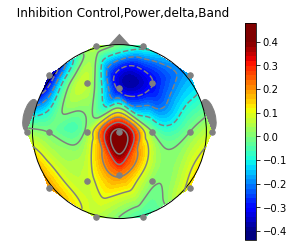

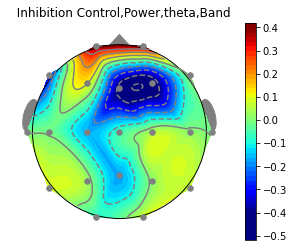

In [29]:
rhytm=np.asarray(('Delta','Theta','Alpha','Beta','High_Beta','Gamma','High_gamma','alpha_1','alpha_2','beta_1','beta_2',
               'beta_3','gamma_1','gamma_2','r_delta','r_theta','r_alpha','r_beta','r_h_beta','r_gamma','r_h_gamma',
               'r_alpha_1','r_alpha_2','r_beta_1','r_beta_2','r_beta_3','r_gamma_1','r_gamma_2'))
address=np.asarray(([-22,79],[22,79],[-30,45],[30,45],[-30,0],[30,0],[30,-45],[-30,-45],[-22,-79],[22,-79],[-65,52],
[65,52],[-65,0],[65,0],[-65,-52],[65,-52],[0,0],[0,40],[0,-40],[-85,0],[85,0]))

koord = address
N = 1000  # number of points for interpolation
xy_center = [0,0]   # center of the plot
radius = 90         # radius
  
for kk in range(2):
    nn=vv[kk*21:(kk+1)*21]
    #plt.close("all") # close old plots
    koord = address
    x,y = [],[]
    for i in koord:
        x.append(i[0])
        y.append(i[1])
    z = nn
    xi = np.linspace(-100, 100, N)
    yi = np.linspace(-100, 100, N)
    zi = scipy.interpolate.griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

# set points > radius to not-a-number. They will not be plotted.
# the dr/2 makes the edges a bit smoother
    dr = xi[1] - xi[0]
    for i in range(N):
        for j in range(N):
            r = np.sqrt((xi[i] - xy_center[0])**2 + (yi[j] - xy_center[1])**2)
            if (r - dr/2) > radius:
                zi[j,i] = "nan"

   # make figure
    fig = plt.figure()
    
    ax = fig.add_subplot(111, aspect = 1)
    CS = ax.contourf(xi, yi, zi, 50, cmap = plt.cm.jet, vmin=-0.4, vmax=0.4,zorder = 1)
    ax.contour(xi, yi, zi, 10, colors = "grey", zorder = 2)
    # make a color bar
    cbar = fig.colorbar(CS, ax=ax)
    ax.scatter(x, y, marker='o', c="grey", s=30, zorder=3)
    circle = matplotlib.patches.Circle(xy = xy_center, radius = 80, edgecolor = "k", facecolor = "none")
    ax.add_patch(circle)
    ax.set_xticks([])
    ax.set_yticks([])

    for loc, spine in ax.spines.items():
        spine.set_linewidth(0)
    circle = matplotlib.patches.Ellipse(xy = [82,15], width = 12, height = 30, angle = 15, edgecolor = "grey", facecolor = "grey", zorder = 0)
    ax.add_patch(circle)
    circle = matplotlib.patches.Ellipse(xy = [-82,15], width = 12, height = 30, angle = -15, edgecolor = "grey", facecolor = "grey", zorder = 0)
    ax.add_patch(circle)
        # add a nose
    xy = [[-13,76], [0,90],[13,76]]
    polygon = matplotlib.patches.Polygon(xy = xy, facecolor = "grey", zorder = 0)
    ax.add_patch(polygon) 
    plt.title('  Inhibition Control,Power,'+rhytm[kk]+',Band')
    #plt.show() 
    plt.savefig('INHIBITION_CONTROL_'+rhytm[kk]+'_Band.png')

In [1]:
# def myBandPower(data, sampling_rate, 
#                 frequency_band1,frequency_band2,frequency_band3,frequency_band4,frequency_band5,frequency_band6,
#                 frequency_band7,frequency_band8,frequency_band9,frequency_band10,
#                 frequency_band11,frequency_band12,frequency_band13,frequency_band14,
#                 method='welch', window_sec=None):
    
#     frequency_band1 = np.asarray(frequency_band1)
#     frequency_band2 = np.asarray(frequency_band2)
#     frequency_band3 = np.asarray(frequency_band3)
#     frequency_band4 = np.asarray(frequency_band4)
#     frequency_band5 = np.asarray(frequency_band5)
#     frequency_band6 = np.asarray(frequency_band6)
#     frequency_band7 = np.asarray(frequency_band7)
#     frequency_band8 = np.asarray(frequency_band8)
#     frequency_band9 = np.asarray(frequency_band9)
#     frequency_band10 = np.asarray(frequency_band10)
#     frequency_band11 = np.asarray(frequency_band11)
#     frequency_band12 = np.asarray(frequency_band12)
#     frequency_band13 = np.asarray(frequency_band13)
#     frequency_band14 = np.asarray(frequency_band14)
    
#     low_limitation1, high_limitation1 = frequency_band1
#     low_limitation2, high_limitation2 = frequency_band2
#     low_limitation3, high_limitation3 = frequency_band3
#     low_limitation4, high_limitation4 = frequency_band4
#     low_limitation5, high_limitation5 = frequency_band5
#     low_limitation6, high_limitation6 = frequency_band6
#     low_limitation7, high_limitation7 = frequency_band7
#     low_limitation8, high_limitation8 = frequency_band8
#     low_limitation9, high_limitation9 = frequency_band9
#     low_limitation10, high_limitation10 = frequency_band10
#     low_limitation11, high_limitation11 = frequency_band11
#     low_limitation12, high_limitation12 = frequency_band12
#     low_limitation13, high_limitation13 = frequency_band13
#     low_limitation14, high_limitation14 = frequency_band14
#     # Compute the modified periodogram (Welch)
#     if method == 'welch':
#         if window_sec is not None:
#             num_of_sample_per_segment = window_sec * sampling_rate
#         else:
#             num_of_sample_per_segment = (2 / low_limitation) * sampling_rate
#         freqs, psd = welch(data, sampling_rate, nperseg=num_of_sample_per_segment)
#     elif method == 'multitaper':
#         psd, freqs = psd_array_multitaper(data, sampling_rate, adaptive=True,
#                                           normalization='full', verbose=0)
#     # Frequency resolution
#     freq_res = freqs[1] - freqs[0]

#     # Find index of band in frequency vector
#     idx_band1 = np.logical_and(freqs >= low_limitation1, freqs <= high_limitation1)
#     idx_band2 = np.logical_and(freqs >= low_limitation2, freqs <= high_limitation2)
#     idx_band3 = np.logical_and(freqs >= low_limitation3, freqs <= high_limitation3)
#     idx_band4 = np.logical_and(freqs >= low_limitation4, freqs <= high_limitation4)
#     idx_band5 = np.logical_and(freqs >= low_limitation5, freqs <= high_limitation5)
#     idx_band6 = np.logical_and(freqs >= low_limitation6, freqs <= high_limitation6)
#     idx_band7 = np.logical_and(freqs >= low_limitation7, freqs <= high_limitation7)
#     idx_band8 = np.logical_and(freqs >= low_limitation8, freqs <= high_limitation8)
#     idx_band9 = np.logical_and(freqs >= low_limitation9, freqs <= high_limitation9)
#     idx_band10 = np.logical_and(freqs >= low_limitation10, freqs <= high_limitation10)
#     idx_band11 = np.logical_and(freqs >= low_limitation11, freqs <= high_limitation11)
#     idx_band12 = np.logical_and(freqs >= low_limitation12, freqs <= high_limitation12)
#     idx_band13 = np.logical_and(freqs >= low_limitation13, freqs <= high_limitation13)
#     idx_band14 = np.logical_and(freqs >= low_limitation14, freqs <= high_limitation14)
#     # Integral approximation of the spectrum using parabola (Simpson's rule)
#     bp1 = simps(psd[idx_band1], dx=freq_res)
#     bp2 = simps(psd[idx_band2], dx=freq_res)
#     bp3 = simps(psd[idx_band3], dx=freq_res)
#     bp4 = simps(psd[idx_band4], dx=freq_res)
#     bp5 = simps(psd[idx_band5], dx=freq_res)
#     bp6 = simps(psd[idx_band6], dx=freq_res)
#     bp7 = simps(psd[idx_band7], dx=freq_res)
#     bp8 = simps(psd[idx_band8], dx=freq_res)
#     bp9 = simps(psd[idx_band9], dx=freq_res)
#     bp10 = simps(psd[idx_band10], dx=freq_res)
#     bp11 = simps(psd[idx_band11], dx=freq_res)
#     bp12 = simps(psd[idx_band12], dx=freq_res)
#     bp13 = simps(psd[idx_band13], dx=freq_res)
#     bp14 = simps(psd[idx_band14], dx=freq_res)
#     bp_general=simps(psd, dx=freq_res)
    
#     bp_r1=bp1/bp_general
#     bp_r2=bp2/bp_general
#     bp_r3=bp3/bp_general
#     bp_r4=bp4/bp_general
#     bp_r5=bp5/bp_general
#     bp_r6=bp6/bp_general
#     bp_r7=bp7/bp_general
#     bp_r8=bp8/bp_general
#     bp_r9=bp9/bp_general
#     bp_r10=bp10/bp_general
#     bp_r11=bp11/bp_general
#     bp_r12=bp12/bp_general
#     bp_r13=bp13/bp_general
#     bp_r14=bp14/bp_general
#     bp=[bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bp11,bp12,bp13,bp14,bp_r1,bp_r2,bp_r3,bp_r4,bp_r5,bp_r6,bp_r7,bp_r8,
#         bp_r9,bp_r10,bp_r11,bp_r12,bp_r13,bp_r14]       
#     return bp

<AxesSubplot:>

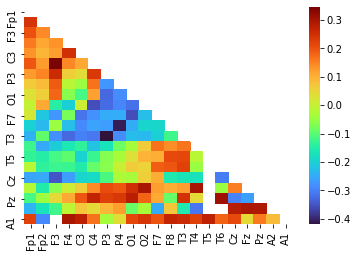

In [29]:
np.random.seed(0)
df = pd.DataFrame(bbb,index=['Fp1','Fp2','F3','F4','C3','C4','P3',
                             'P4','O1','O2','F7','F8','T3','T4','T5','T6','Cz','Fz','Pz','A2','A1']
                  ,columns=['Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5',
                               'T6','Cz','Fz','Pz','A2','A1'],  )
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df, mask=mask, square=False,cmap="turbo")
#g.set_yticklabels( ['Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','Cz','Fz','Pz','A2','A1'])

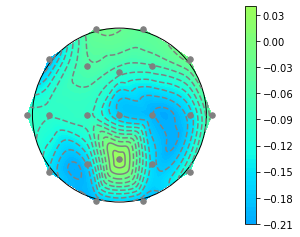

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
# close old plots
plt.close("all")

# some parameters
N = 1000            # number of points for interpolation
xy_center = [0,0]   # center of the plot
radius = 90         # radius

# mostly original code

koord = address
x,y = [],[]
for i in koord:
    x.append(i[0])
    y.append(i[1])
z = nn
xi = np.linspace(-100, 100, N)
yi = np.linspace(-100, 100, N)
zi = scipy.interpolate.griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

# set points > radius to not-a-number. They will not be plotted.
# the dr/2 makes the edges a bit smoother
dr = xi[1] - xi[0]
for i in range(N):
    for j in range(N):
        r = np.sqrt((xi[i] - xy_center[0])**2 + (yi[j] - xy_center[1])**2)
        if (r - dr/2) > radius:
            zi[j,i] = "nan"

# make figure
fig = plt.figure()

# set aspect = 1 to make it a circle
ax = fig.add_subplot(111, aspect = 1)

# use different number of levels for the fill and the lines
CS = ax.contourf(xi, yi, zi, 50, cmap = plt.cm.jet, vmin=-0.5, vmax=0.5,zorder = 1)
ax.contour(xi, yi, zi, 10, colors = "grey", zorder = 2)
# make a color bar
cbar = fig.colorbar(CS, ax=ax)

ax.scatter(x, y, marker='o', c="grey", s=30, zorder=3)

# draw a circle
# change the linewidth to hide the 
circle = matplotlib.patches.Circle(xy = xy_center, radius = 80, edgecolor = "k", facecolor = "none")
ax.add_patch(circle)
ax.set_xticks([])
ax.set_yticks([])

# make the axis invisible 
for loc, spine in ax.spines.items():
    # use ax.spines.items() in Python 3
    spine.set_linewidth(0)

# remove the ticks
#ax.set_xticks([])
#ax.set_yticks([])

# Add some body parts. Hide unwanted parts by setting the zorder low

# set axes limits
#ax.set_xlim(-120, 120)
#ax.set_ylim(-120, 120)

plt.show() 

In [ ]:
fig, ax = plt.subplots(1)
im = ax.matshow(scores, vmin=0, vmax=1., cmap='RdBu_r', origin='lower',
                extent=epochs.times[[0, -1, 0, -1]])
ax.axhline(0., color='k')
ax.axvline(0., color='k')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Generalization across time and condition')
plt.colorbar(im, ax=ax)
plt.show()

In [ ]:
import mne
import matplotlib.pyplot as plt 
#from topograph import plot_topomap

fig, ax = plt.subplots(figsize=(200,200))
mne.viz.plot_topomap(nn, add)
plt.show()
#fig.savefig("topograph.png", bbox_inches='tight')

In [32]:
###collct_all_fetures_with_pvalue_more_than_0.4###
#####Attention#####

#phase_del
#selected_phase_diff_all_del=phase_diff_all_del[:,sig]
#s1=selected_phase_diff_all_del.reshape(38,25)

#amp_del
#selected_amp_del=amplitude_asymmetry_del[:,sig]
#s2=selected_amp_del.reshape(38,21)

#coh_del
#selected_coherence_all_del=coherence_all_del[:,sig]
#s3=selected_coherence_all_del.reshape(38, 813)

selected_feature=np.concatenate((s1,s2,s3),axis=1)
#s_all=np.append(selected_feature)

##sort features according to sorted lables namely congnitive scores   
selected_feature_sorted=np.empty((selected_feature.shape[0],selected_feature.shape[1]))
for idx in range(selected_feature.shape[0]):
    selected_feature_sorted[idx,:]=selected_feature[sort_index_a[idx],:]

In [141]:
ry1=[]
ry2=[]
ry3=[]
ry4=[]
ry5=[]
ry6=[]
ry7=[]
ry8=[]
ry9=[]
ry10=[]

for i in range( 441):
    ry1.append('delta')
    ry2.append('theta')
    ry3.append('alpha')
    ry4.append('beta')
    ry5.append('h_beta')
    ry6.append('beta_1')
    ry7.append('beta_2')
    ry8.append('beta_3')
    ry9.append('gamma_1')
    ry10.append('gamma_2')
    
ry_phase=np.vstack([ry1,ry2,ry3,ry4,ry5,ry6,ry7,ry8,ry9,ry10])
freq_phase=ry_phase.reshape(4410)

In [67]:
score=EF
feature= coh
vv=np.empty((feature.shape[1]))
rr=np.empty((feature.shape[1]))
for ii in range((feature.shape[1])):
    #h1=scipy.stats.mstats.spearmanr(score,feature[:,ii]) 
    h1=scipy.stats.pearsonr(score,feature[:,ii])  
    vv[ii]=h1[0]
    rr[ii]=h1[1]
sig=np.argwhere(vv>0.3)
nig=np.argwhere(vv<-0.3)

#for idd in range(len((sig))):
    #print((jj1[0,sig[idd]],jj2[0,sig[idd]],freq_address[sig[idd]],("%.3f" %(vv[sig[idd]])),("%.5f" %(rr[sig[idd]]))))  
    

In [38]:
score=MEM
feature= phase
vv=np.empty((feature.shape[1]))
rr=np.empty((feature.shape[1]))
for ii in range((feature.shape[1])):
    #h1=scipy.stats.mstats.spearmanr(score,feature[:,ii]) 
    h1=scipy.stats.pearsonr(score,feature[:,ii])  
    vv[ii]=h1[0]
    rr[ii]=h1[1]
sig=np.argwhere(vv>0.3)
nig=np.argwhere(vv<-0.3)
print(nig)

#for idd in range(len((sig))):
    #print((jj1[0,sig[idd]],jj2[0,sig[idd]],freq_address[sig[idd]],("%.3f" %(vv[sig[idd]])),("%.5f" %(rr[sig[idd]]))))  
    

[[ 159]
 [ 179]
 [ 200]
 [ 201]
 [ 221]
 [ 222]
 [ 243]
 [ 265]
 [ 266]
 [ 267]
 [ 287]
 [ 288]
 [ 369]
 [ 397]
 [ 398]
 [ 651]
 [ 684]
 [ 712]
 [ 792]
 [ 798]
 [ 799]
 [ 823]
 [ 870]
 [1013]
 [1026]
 [1047]
 [1104]
 [1125]
 [1239]
 [1240]
 [1241]
 [1242]
 [1257]
 [1298]
 [1446]
 [1884]
 [1909]
 [1910]
 [1930]
 [1951]
 [1993]
 [1995]
 [1996]
 [1997]
 [1998]
 [1999]
 [2053]
 [2088]
 [2089]
 [2184]
 [2185]
 [2186]
 [2243]
 [2279]
 [2344]
 [2346]
 [2539]
 [2540]
 [2927]
 [2928]
 [3105]
 [3126]
 [3647]
 [3673]
 [3674]
 [3905]
 [3953]
 [4089]
 [4232]]


In [34]:
#lable
m_cls3_lable=np.zeros((15))+3
m_cls2_lable=np.zeros((23))+2
m_cls1_lable=np.zeros((13))+1
m_lables=np.concatenate((m_cls1_lable,m_cls2_lable,m_cls3_lable))

a_cls3_lable=np.zeros((20))+3
a_cls2_lable=np.zeros((11))+2
a_cls1_lable=np.zeros((7))+1
a_lables=np.concatenate((a_cls1_lable,a_cls2_lable,a_cls3_lable))

e_cls3_lable=np.zeros((15))+3
e_cls2_lable=np.zeros((23))+2
e_cls1_lable=np.zeros((13))+1
e_lables=np.concatenate((e_cls1_lable,e_cls2_lable,e_cls3_lable))

i_cls3_lable=np.zeros((15))+3
i_cls2_lable=np.zeros((23))+2
i_cls1_lable=np.zeros((13))+1
i_lables=np.concatenate((i_cls1_lable,i_cls2_lable,i_cls3_lable))

In [36]:
lables=a_lables
features=selected_feature_sorted
from sklearn.model_selection import LeaveOneOut
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
loo=LeaveOneOut()
for train,test in loo.split(features):
    rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(features[train,:], lables[train])
    rbf_pred = rbf.predict(features[test,:])
    rbf_accuracy = accuracy_score(lables[test], rbf_pred)
    rbf_f1 = f1_score(lables[test], rbf_pred, average='weighted')
    print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
    #print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  0.00
Accuracy (RBF Kernel):  100.00
Accuracy (RBF Kernel):  100.00
Accuracy (RBF Kernel):  100.00
Accuracy (RBF Kernel):  100.00
Accuracy (RBF Kernel):  100.00
Accuracy (RBF Kernel):  100.00
Accuracy (RBF Kernel):  100.00
Accuracy (RBF Kernel):  100.00
Accuracy (RBF Kernel):  100.00
Accuracy (RBF Kernel):  100.00
Accuracy (RBF Kernel):  100.00
Accuracy (RBF Kernel):  100.00
Accuracy (RBF Kernel):  100.00
Accuracy (RBF Kernel):  100.00
Accuracy (RBF Kernel):  100.00
Accuracy (RBF

In [6]:
vv.shape

(4410,)

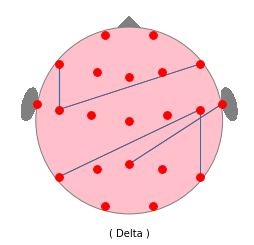

<Figure size 432x288 with 0 Axes>

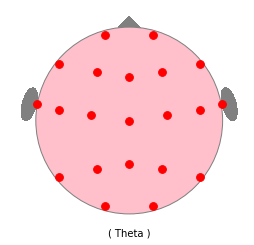

<Figure size 432x288 with 0 Axes>

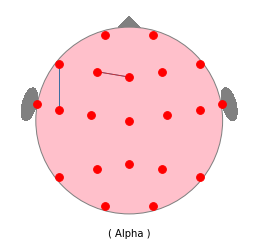

<Figure size 432x288 with 0 Axes>

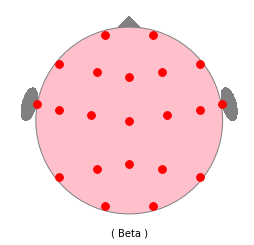

<Figure size 432x288 with 0 Axes>

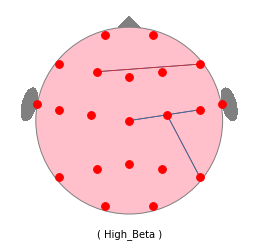

<Figure size 432x288 with 0 Axes>

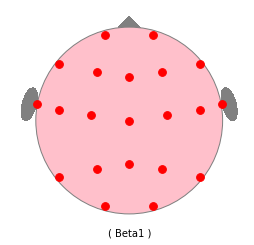

<Figure size 432x288 with 0 Axes>

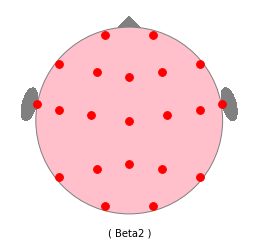

<Figure size 432x288 with 0 Axes>

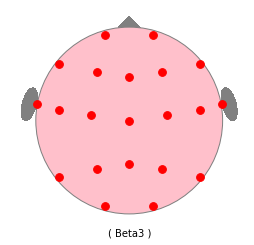

<Figure size 432x288 with 0 Axes>

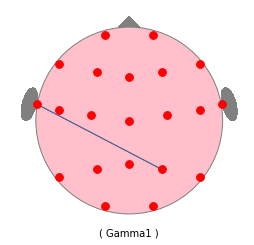

<Figure size 432x288 with 0 Axes>

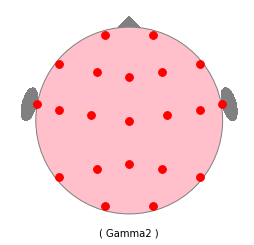

<Figure size 432x288 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
rhytm=np.asarray(['Delta','Theta','Alpha','Beta','High_Beta','Beta1','Beta2','Beta3','Gamma1','Gamma2'])
gg=vv.reshape(10,21,21)
for jk in range(10):
    vvvv=gg[jk,:,:]
#['Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5', 'T6','Cz','Fz','Pz','A2','A1'])
    address=np.asarray(([-22,79],[22,79],[-30,45],[30,45],[-35,5],[35,5],[30,-45],[-30,-45],[-22,-79],[22,-79],[-65,52],
    [65,52],[-65,10],[65,10],[-65,-52],[65,-52],[0,0],[0,40],[0,-40],[-85,15],[85,15]))
    koord = address
    N = 1000  # number of points for interpolation
    xy_center = [0,0]   # center of the plot
    radius = 90         # radius
  
    #plt.close("all") # close old plots
    koord = address
    x,y = [],[]
    for i in koord:
        x.append(i[0])
        y.append(i[1])
    xi = np.linspace(-100, 100, N)
    yi = np.linspace(-100, 100, N)
# set points > radius to not-a-number. They will not be plotted.
# the dr/2 makes the edges a bit smoother
    dr = xi[1] - xi[0]
   # make figure
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect = 1)
    ax.scatter(x, y, marker='o', c="red", s=60, zorder=3)
    circle = matplotlib.patches.Circle(xy = xy_center, radius = 86, edgecolor = "grey",facecolor = "pink")
    ax.add_patch(circle)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('( '+rhytm[jk]+' )')
    for loc, spine in ax.spines.items():
        spine.set_linewidth(0)
    lw=0
    col=()
    for i in range(21):
        for j in range(21):
            weight=vvvv[i][j]
            if weight >= 0.4:
                lw=abs(weight*2)
                col='tab:blue'
            elif -0.4 <weight <0.4:
                lw=0
                col='tab:grey'
            elif weight <= -0.4:
                 lw=abs(weight*2)
                 col='tab:red'
            plt.plot((x[i],x[j]), (y[i],y[j]),col,linewidth=lw)
        # add two ears
            circle = matplotlib.patches.Ellipse(xy = [92,15], width = 12, height = 30, angle = 15, edgecolor = "grey", facecolor = "grey", zorder = 0)
            ax.add_patch(circle)
            circle = matplotlib.patches.Ellipse(xy = [-92,15], width = 12, height = 30, angle = -15, edgecolor = "grey", facecolor = "grey", zorder = 0)
            ax.add_patch(circle)
        # add a nose
            xy = [[-10,86], [0,96],[10,86]]
            polygon = matplotlib.patches.Polygon(xy = xy, facecolor = "grey", zorder = 0)
            ax.add_patch(polygon) 
            
    #plt.show()
    #plt.savefig('coh_EF_'+rhytm[jk]+'_Band.svg')
    
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig('2phase_MEM_'+rhytm[jk]+'_Band.png', dpi=100)

In [11]:
sort_index_m=np.argsort(MEMORY)
sort_index_a=np.argsort(ATTENTION)
sort_index_e=np.argsort(EXECUTIVE_FUNCTION)
sort_index_i=np.argsort(INHIBITION_CONTROL)

MEMORY_sorted=np.empty(len(MEMORY))
ATTENTION_sorted=np.empty(len(MEMORY))
EXECUTIVE_FUNCTION_sorted=np.empty(len(MEMORY))
INHIBITION_CONTROL_sorted=np.empty(len(MEMORY))

for index in range(len(MEMORY)):
    MEMORY_sorted[index]=MEMORY[sort_index_m[index]]
    ATTENTION_sorted[index]=ATTENTION[sort_index_a[index]]
    EXECUTIVE_FUNCTION_sorted[index]=EXECUTIVE_FUNCTION[sort_index_e[index]]
    INHIBITION_CONTROL_sorted[index]=INHIBITION_CONTROL[sort_index_i[index]]

In [5]:
#!/usr/bin/python

import sys
import numpy as np
import multiprocessing


class Data:
    def __init__(self,x,y):
        self.x = x
        self.y = y

def sort_data(data_list):
    o = sorted(data_list,key=lambda Data:Data.x)
    ##insert sorting
    tied_x=[];i=0;l=len(o)
    while i<l-1:
        if o[i].x == o[i+1].x:
            t=[i,i+1]
            while 1:
                i +=  1;
                if i+1 == l:tied_x.append(t);break
                if o[i].x == o[i+1].x:t.append(i+1)
                else: i -= 1;tied_x.append(t);break
        i += 1
    return o,tied_x

def shuffle_Y(o,tied_x):
    for i in tied_x:
        Y=[]
        for j in i:
            Y.append(o[j].y)
        new=np.random.permutation(Y)
        k=0
        for j in i:
            o[j].y=new[k]
            k += 1
    return o

def show(o):
    x=[];y=[]
    for i in o:
        x.append(str(i.x))
        y.append(str(i.y))
        
def cal_observe_W(o,k=2):
    w=0;rank=0
    for i in o:
        r1=max(rank-k+1,0)
        #r2=min(len(o),rank+k)
        for j in range(r1,rank):
            w += (i.y-o[j].y)*(i.y-o[j].y)
        rank += 1
    return w

def Permutation(o,loop,k):
    w=[]
    for i in range(loop):
        Y=[];n=o
        for i in o:
            Y.append(i.y)
            new=np.random.permutation(Y)
        for i,j in zip(n,new):
            i.y=j
            w.append(cal_observe_W(n,k))
    return w

def canova(x,y,permutation=10,shuffle_times=100,k=2,threads=10):
    data_list = list_to_data(x,y)
    o,tie=sort_data(data_list)
    w=[]
    if len(tie) != 0:
        for i in range(shuffle_times):
            n=shuffle_Y(o,tie)
            w.append(cal_observe_W(n,k))
    else: w=[cal_observe_W(o,k)]
    aver_w=float(sum(w))/float(len(w))
    #permutation
    #multiprocessing
    pool = multiprocessing.Pool(processes=threads)
    each_loop = int(permutation/threads)
    result = []
    for i in range(threads-1):
        result.append(pool.apply_async(Permutation, (o,each_loop,k, )))
    rest = permutation - each_loop*(threads-1)
    result.append(pool.apply_async(Permutation, (o,rest,k, )))
    pool.close()
    pool.join()
    
    count = 0
    for res in result:
        for i in res.get():
            if i<=aver_w: count +=1
    p=float(count)/float(permutation)
    return p

def list_to_data(x,y):
    o=[]
    for i,j in zip(x,y):
        o.append(Data(int(i),int(j)))
    return o